In [1]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset
from data_utils import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline  

In [2]:
dataset_name = 'cifar100'
metric = 'overall_accuracy' # 'ece', 'confusion_matrix'
group_method = 'score'
pseudocount = 2
output = pathlib.Path("../output/active_learning_low_variance")
random_state = 0
RUNS = 10
LOG_FREQ = 10

In [3]:
from scipy.stats import beta

def random_sampling(deques: List[deque], 
                    **kwargs) -> Union[int, List[int]]:
    while True:
        category = random.randrange(len(deques))
        if len(deques[category]) != 0:
            return category

def thompson_sampling(deques: List[deque],
                      reward: List[float], #(num_groups, )
                     ) -> Union[int, List[int]]:
    ranked = np.argsort(reward)
    for category in ranked:
        if len(deques[category]) != 0:
            return category

SAMPLE_CATEGORY = {
    'random': random_sampling,
    'ts': thompson_sampling,
}

In [4]:
def select_and_label(dataset: 'Dataset', sample_method: str, prior=None) -> np.ndarray:
    
    if metric in ['overall_accuracy', 'most_accurate', 'least_accurate']:
        model = BetaBernoulli(dataset.num_groups, prior=prior, weight=dataset.weight_k)
        deques = dataset.enqueue()
    else:
        return 

    sampled_indices = np.zeros((dataset.__len__(),), dtype=np.int) # indices of selected data points
    mpe_log = np.zeros((dataset.__len__() // LOG_FREQ, dataset.num_groups))
    
    sample_fct = SAMPLE_CATEGORY[sample_method]

    idx = 0
    while idx < dataset.__len__():
        if sample_method == 'ts':
            reward = model.reward(reward_type=metric)
        else:
            reward=None
        category = sample_fct(deques=deques, reward=reward)
        selected = deques[category].pop() # a dictionary
        model.update(category, selected)
        sampled_indices[idx] = selected['index']
        if (idx+1) % LOG_FREQ == 0:
            mpe_log[idx // LOG_FREQ] = model.mpe
        idx += 1

    return sampled_indices,  mpe_log

In [5]:
def run() -> None:

    experiment_name = '%s_%s_runs%d_pseudocount%.2f' % (dataset_name, metric, RUNS, pseudocount)
    if not (output / experiment_name).is_dir():
        (output / experiment_name).mkdir()

    method_list = ['non_active', 'ts_uniform', 'ts_informed']
    
    samples = {}
    mpe_log = {}
    for method in method_list:
        samples[method] = {}
        mpe_log[method] = {}
        for r in range(RUNS):
            samples[method][r] = {}
            mpe_log[method][r] = {}

    for r in tqdm(range(RUNS)):
        dataset = Dataset.load_from_text(dataset_name)
        dataset.group(group_method = group_method)
        dataset.shuffle(random_state)

        UNIFORM_PRIOR = np.ones((dataset.num_groups, 2)) / 2 * pseudocount
        INFORMED_PRIOR = np.array([dataset.confidence_k, 1 - dataset.confidence_k]).T * pseudocount
        INFORMED_PRIOR[np.isnan(INFORMED_PRIOR)] = 1.0 / 2 * pseudocount
    
        samples['non_active'][r], mpe_log['non_active'][r] = select_and_label(dataset, sample_method='random', 
                                                               prior=UNIFORM_PRIOR * 1e-6)
        samples['ts_uniform'][r], mpe_log['ts_uniform'][r] = select_and_label(dataset, sample_method='ts', 
                                                               prior=UNIFORM_PRIOR)
        samples['ts_informed'][r], mpe_log['ts_informed'][r] = select_and_label(dataset, sample_method='ts', 
                                                                prior=INFORMED_PRIOR)
    # write samples to file
    for method in method_list:
        np.save(output / experiment_name / ('samples_%s.npy' % method), samples[method])
        np.save(output / experiment_name / ('mpe_log_%s.npy' % method), mpe_log[method])
    return samples, mpe_log

In [6]:
samples, mpe_log = run()

100%|██████████| 10/10 [01:05<00:00,  6.53s/it]


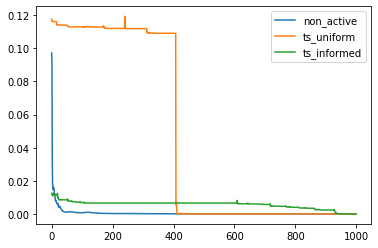

In [14]:
method_list = ['non_active', 'ts_uniform', 'ts_informed']

dataset = Dataset.load_from_text(dataset_name)
dataset.group(group_method = group_method)

for method_name in method_list:
    estimation_error = np.zeros((RUNS, dataset.__len__() // LOG_FREQ))
    for run_id in range(RUNS):
        accuracy_k = dataset.accuracy_k
        accuracy_k[np.isnan(accuracy_k)] = 0
        estimation_error[run_id] = np.inner((mpe_log[method_name][run_id] - accuracy_k)**2, dataset.weight_k)
    plt.plot(estimation_error.mean(axis=0), label=method_name)
    plt.legend()

In [13]:
dataset.accuracy_k

array([       nan, 0.16666667, 0.18589744, 0.25072046, 0.36068702,
       0.39300699, 0.4525661 , 0.54332875, 0.67157895, 0.92922297])